# Using Neural Networks to determine O/H from strong lines

## Following the paper of Marino et al 2013, artificial neural networks is used to compute a fit to the observed relation between some strong lines and the oxygen abundance.

## The ANN is defined, trained and used with the help of the TMNIAI (Taller Mexicano de Nebulosas Ionizadas: Mexican Group on Ionized Nenulae with Artificial Intelligence MGINAI) package. The package is freely available on the TMNI github repository: https://github.com/taller-mexicano-de-nebulosas-ionizadas/AI

***

### First import some useful libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Import the TMNIAI library. If not installed, install it.

In [2]:
try:
    import mwinai
except:
    !pip install -U git+https://github.com/taller-mexicano-de-nebulosas-ionizadas/AI.git
    import mwinai

/home/morisset/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


### The data are downloaded for the SDC using astropy.

In [3]:
from astropy.table import Table
t = Table.read('ftp://cdsarc.u-strasbg.fr/ftp/J/A+A/559/A114/table4.dat', 
               format='ascii.cds', 
               readme='ftp://cdsarc.u-strasbg.fr/ftp/J/A+A/559/A114/ReadMe')

W0925 14:46:41.617420 140200327501632 logger.py:200] UnitsWarning: '[-]' did not parse as cds unit: Invalid character at col 0


### Have a look at the data:

In [4]:
t

Ref,ID,[O3N2],[N2],Ab(O)
,,[-],[-],
int64,str17,float64,float64,float64
12,M51CCM10,-0.75734,-0.40722,8.561
12,M51CCM53,-0.34834,-0.37722,8.661
12,M51CCM54,-0.25934,-0.37022,8.53
12,M51CCM55,-0.58034,-0.38822,8.634
12,M51CCM72,-0.97234,-0.45622,8.669
12,M51CCM84A,-0.02034,-0.29822,8.528
12,NGC1232no04,1.46966,-1.11422,8.23
12,NGC1232no06,-0.04634,-0.50222,8.467


### The data are plotted like in Fig. 2 of Marino et al. 2013

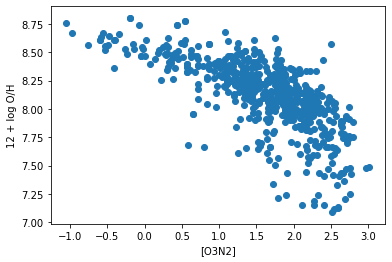

In [5]:
diag = '[O3N2]'
f, ax = plt.subplots()
ax.scatter(t[diag], t['Ab(O)'])
ax.set_xlabel(diag)
ax.set_ylabel('12 + log O/H');

### A Regression Model object is instantiated. Some parameters already appear here: 
- ### 'ANN' from Scikit is used.
- ### X_train and y_train sets are from the Marino's data.
- ### The X data are scaled in a preprocessing step.
- ### A random_seed is set to be able to obtain the same result in various run.

In [6]:
RM = mwinai.manage_RM(RM_type='SK_ANN', 
                  X_train=t[diag], 
                  y_train=t['Ab(O)'],
                  scaling=True, 
                  verbose=True, 
                  random_seed=10)

Instantiation. V 0.15
Training set size = 624, Test set size = 0
Train data scaled.
Test data scaled.
Training set size = 624, Test set size = 0
Training set size = 624, Test set size = 0


### The artificial neural network is defined by seting some parameters:
- ### The structure of the NN is defined by the number neurons in each hidden layer.
- ### A tolerance is given for the convergence process to stop.
- ### A maximum number of iteration is givento stop the convergence process if not reaching the tolerance limit.
- ### The activation function of all the cells in the NN is given.
- ### The solver for the convergence is given.

In [7]:
RM.init_RM(hidden_layer_sizes=(100,100), 
           tol=1e-6, 
           max_iter=10000, 
           activation='logistic',
           solver='adam')

Regression Model SK_ANN


### The model is now trained. That may take a while, depending on the size of the network and the number of iterations.
### As we set the verbosity to True, some output appears.

In [8]:
RM.train_RM()

Training 1 inputs for 1 outputs with 624 data
RM trained, with 286 iterations. Score = 0.513
MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100), learning_rate='constant',
             learning_rate_init=0.001, max_iter=10000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=10, shuffle=True, solver='adam', tol=1e-06,
             validation_fraction=0.1, verbose=False, warm_start=False)
Training time 1.2 s.


### Define the X data set on which the regression will be tested. 
### Minimum and maximum values of Marino data set are used.

In [9]:
X_test = np.linspace(np.min(t[diag]), np.max(t[diag]), 500)

### Enter the X_test values to the object. Do not forget to scale them, using the same scaling than for the training data.

In [10]:
RM.set_test(X_test)

Test data scaled.
Training set size = 624, Test set size = 500


### The network makes the predictions corresponding to the X_test data set. The result of the prediction is stored in the RM object.

In [11]:
RM.predict(scoring=False)

Predicting from 1 inputs to 1 outputs using 500 data in 0.00 secs.


### Store the predictions in the y variable

In [12]:
y = RM.pred

### Draw the plot comparing the training set and the prediction.

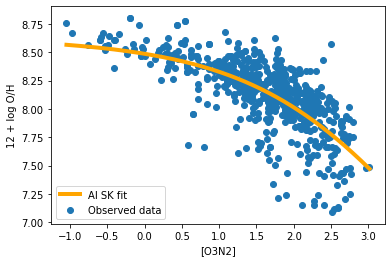

In [13]:
f, ax = plt.subplots()
ax.scatter(t[diag], t['Ab(O)'], label='Observed data')
ax.plot(X_test, y, linewidth=4, c='orange', label='AI SK fit')
ax.set_xlabel(diag)
ax.set_ylabel('12 + log O/H')
ax.legend();

### Store the object into another variable RM1 for a further use.

In [14]:
RM1=RM

### The same process is repeated, but this time with the N2 as metallicity diagnostic. The resulting object is stored in RM2.

Instantiation. V 0.15
Training set size = 624, Test set size = 500
Train data scaled.
Test data scaled.
Training set size = 624, Test set size = 500
Training set size = 624, Test set size = 500
Regression Model SK_ANN
Training 1 inputs for 1 outputs with 624 data
RM trained, with 73 iterations. Score = 0.709
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100), learning_rate='constant',
             learning_rate_init=0.001, max_iter=10000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=20, shuffle=True, solver='lbfgs', tol=1e-06,
             validation_fraction=0.1, verbose=False, warm_start=False)
Training time 0.2 s.
Predicting from 1 inputs to 1 outputs using 500 data in 0.00 secs.


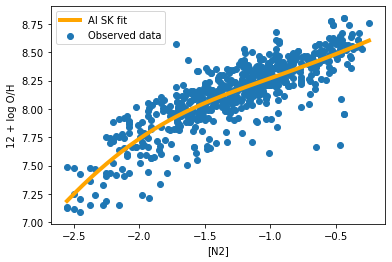

In [15]:
diag = '[N2]'
X_test = np.linspace(np.min(t[diag]), np.max(t[diag]), 500)
RM = mwinai.manage_RM(RM_type='SK_ANN', 
                  X_train=t[diag], 
                  y_train=t['Ab(O)'], 
                  X_test=X_test,
                  scaling=True,
                  verbose=True, 
                  random_seed=20)
RM.init_RM(hidden_layer_sizes=(100,100), 
           tol=1e-6, 
           max_iter=10000, 
           activation='tanh',
           solver='lbfgs')
RM.train_RM()
RM.predict(scoring=False)
y = RM.pred
RM2 = RM
f, ax = plt.subplots()
ax.scatter(t[diag], t['Ab(O)'], label='Observed data')
ax.plot(X_test, y, linewidth=4, c='orange', label='AI SK fit')
ax.set_xlabel(diag)
ax.set_ylabel('12 + log O/H')
ax.legend();

### Change the library to the Keras/Tensorflow one. Only a few parameters need to be updated (namely: epochs in the init method)
### The plot compares the Scikit and Tensorflow results.

W0925 14:46:43.510834 140200327501632 deprecation_wrapper.py:119] From /home/morisset/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0925 14:46:43.511934 140200327501632 deprecation_wrapper.py:119] From /home/morisset/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0925 14:46:43.513749 140200327501632 deprecation_wrapper.py:119] From /home/morisset/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0925 14:46:43.536892 140200327501632 deprecation_wrapper.py:119] From /home/morisset/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Instantiation. V 0.15
Training set size = 624, Test set size = 500
Train data scaled.
Test data scaled.
Training set size = 624, Test set size = 500
Training set size = 624, Test set size = 500


W0925 14:46:43.684956 140200327501632 deprecation_wrapper.py:119] From /home/morisset/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________
Regression Model K_ANN
Training 1 inputs for 1 outputs with 624 data


W0925 14:46:43.740081 140200327501632 deprecation_wrapper.py:119] From /home/morisset/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



RM trained. Score = nan
Training time 1.7 s.
Predicting from 1 inputs to 1 outputs using 500 data in 0.03 secs.


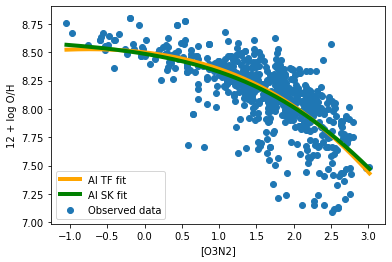

In [16]:
diag = '[O3N2]'
X_test = np.linspace(np.min(t[diag]), np.max(t[diag]), 500)
RM = mwinai.manage_RM(RM_type='K_ANN',
                  X_train=t[diag], 
                  y_train=t['Ab(O)'], 
                  X_test=X_test,
                  scaling=True, 
                  verbose=True, 
                  random_seed=20)
RM.init_RM(hidden_layer_sizes=(100,20), 
           activation='tanh',
           solver='adam', 
           epochs=100)
RM.train_RM()
RM.predict(scoring=False)
y = RM.pred
f, ax = plt.subplots()
ax.scatter(t[diag], t['Ab(O)'], label='Observed data')
ax.plot(X_test, y, linewidth=4, c='orange', label='AI TF fit')
ax.plot(X_test, RM1.pred, linewidth=4, c='green', label='AI SK fit')
ax.set_xlabel(diag)
ax.set_ylabel('12 + log O/H')
ax.legend();

#### Take care that the differences between the 2 libraries shown here may be dominated by the values of the hyper parameters used for each library, and do not reflect the capacity of the library to fit the data.

### The same comparison is performed for the N2 diagnostic.

Instantiation. V 0.15
Training set size = 624, Test set size = 500
Train data scaled.
Test data scaled.
Training set size = 624, Test set size = 500
Training set size = 624, Test set size = 500
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 3,261
Trainable params: 3,261
Non-trainable params: 0
_________________________________________________________________
Regression Model K_ANN
Training 1 inputs for 1 outputs with 624 data
RM trained. Score = nan
Training time 1.8 s.
Predicting from 1 inputs to 1 outputs using 500 data in 0.04 secs.


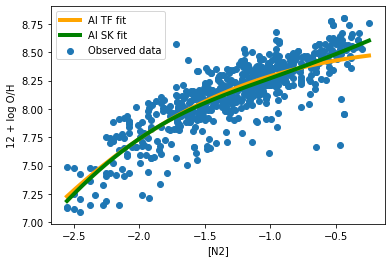

In [17]:
diag = '[N2]'
X_test = np.linspace(np.min(t[diag]), np.max(t[diag]), 500)
RM = mwinai.manage_RM(RM_type='K_ANN',
                  X_train=t[diag], 
                  y_train=t['Ab(O)'], 
                  X_test=X_test,
                  scaling=True, 
                  verbose=True, 
                  random_seed=20)
RM.init_RM(hidden_layer_sizes=(100,30), 
           activation='tanh',
           solver='adam', 
           epochs=100)
RM.train_RM()
RM.predict(scoring=False)
y = RM.pred
f, ax = plt.subplots()
ax.scatter(t[diag], t['Ab(O)'], label='Observed data')
ax.plot(X_test, y, linewidth=4, c='orange', label='AI TF fit')
ax.plot(X_test, RM2.pred, linewidth=4, c='green', label='AI SK fit')
ax.set_xlabel(diag)
ax.set_ylabel('12 + log O/H')
ax.legend();